# Adding Dynamic Features To Improve Energy Usage Predictions

## Part 1: Load and examine the data

In [1]:
data_bucket = 'mlforbusiness'
subfolder = 'ch07'
s3_data_path = f"s3://{data_bucket}/{subfolder}/data"
s3_output_path = f"s3://{data_bucket}/{subfolder}/output"

In [2]:
%matplotlib inline

from dateutil.parser import parse
import json
import random
import datetime
import os

import pandas as pd                               
import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

role = sagemaker.get_execution_role()
s3 = s3fs.S3FileSystem(anon=False)
s3_data_path = f"s3://{data_bucket}/{subfolder}/data"
s3_output_path = f"s3://{data_bucket}/{subfolder}/output"

In this chapter we will be dealing with 5 files. Our meter readings have already been summarised into daily totals and can be found in "Meter Data.csv". We also have a "Site Categories.csv" file which records whether each site belongs to the Retail, Industrial, or Transport industries. We will use this as a static "Category" feature. There is a further file which contains time series data regarding holidays. This is "Site Holidays.csv". Finally we have maximum temperatures in "Site Maxima.csv" These will be our models "dynamic features".

In [3]:
# First we check our meter data
daily_df = pd.read_csv(f's3://{data_bucket}/{subfolder}/meter_data_daily.csv', index_col=0, parse_dates=[0])
daily_df.index.name = None
daily_df.head()

,Site_1,Site_2,Site_3,Site_4,Site_5,Site_6,Site_7,Site_8,Site_9,Site_10,...,Site_39,Site_40,Site_41,Site_42,Site_43,Site_44,Site_45,Site_46,Site_47,Site_48
2017-11-01,1184.23,1039.1,985.95,1205.07,NaN,6684.4,1192.1,1256.1,982.6,1001.4,...,1548.92,NaN,NaN,NaN,1573.23,2871.58,2303.38,2977.41,2672.10,2298.95
2017-11-02,1210.90,1084.7,1013.91,1252.44,NaN,6894.3,1238.6,1249.4,1023.6,997.4,...,1539.52,NaN,NaN,NaN,1537.35,2890.60,2290.59,2988.84,2658.95,2112.39
2017-11-03,1247.60,1004.2,963.95,1222.40,NaN,6841.0,1174.3,1210.3,990.3,1009.3,...,1487.40,NaN,NaN,NaN,1615.69,2737.92,2289.75,2898.06,2642.38,2475.31
2017-11-04,1246.92,936.2,877.97,1157.45,NaN,6079.1,1041.2,1086.7,879.3,854.7,...,325.96,NaN,NaN,NaN,888.55,1726.20,2127.39,2617.02,1429.63,564.29
2017-11-05,1189.20,830.8,798.97,975.69,NaN,5221.5,929.4,1068.0,767.7,785.8,...,318.24,NaN,NaN,NaN,867.91,1849.85,2124.23,2320.60,726.15,554.00


In [4]:
print(daily_df.shape)
print(f'Time series starts at {daily_df.index[0]} and ends at {daily_df.index[-1]}')

(485, 48)
Time series starts at 2017-11-01 00:00:00 and ends at 2019-02-28 00:00:00


In [5]:
category_df = pd.read_csv(f's3://{data_bucket}/{subfolder}/site_categories.csv',index_col=0).reset_index(drop=True)
print(category_df.shape)
print(category_df.Category.unique())
category_df.head()

(48, 2)
['Retail' 'Industrial ' 'Transport']


,Site,Category
0,1,Retail
1,2,Retail
2,3,Retail
3,4,Retail
4,5,Retail


In [6]:
holiday_df = pd.read_csv(f's3://{data_bucket}/{subfolder}/site_holidays.csv', index_col=0, parse_dates=[0])
print(holiday_df.shape)
print(f'Time series starts at {holiday_df.index[0]} and ends at {holiday_df.index[-1]}')
holiday_df.loc['2018-12-22':'2018-12-27']

(485, 48)
Time series starts at 2017-11-01 00:00:00 and ends at 2019-02-28 00:00:00


,Site_1_hol,Site_2_hol,Site_3_hol,Site_4_hol,Site_5_hol,Site_6_hol,Site_7_hol,Site_8_hol,Site_9_hol,Site_10_hol,...,Site_39_hol,Site_40_hol,Site_41_hol,Site_42_hol,Site_43_hol,Site_44_hol,Site_45_hol,Site_46_hol,Site_47_hol,Site_48_hol
2018-12-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-12-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-12-24,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,0,0,0,0,0,0
2018-12-25,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2018-12-26,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2018-12-27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
max_df = pd.read_csv(f's3://{data_bucket}/{subfolder}/site_maximums.csv', index_col=0, parse_dates=[0])
print(max_df.shape)
print(f'Time series starts at {max_df.index[0]} and ends at {max_df.index[-1]}')
max_df.loc['2018-12-22':'2018-12-27']

(485, 48)
Time series starts at 2017-11-01 00:00:00 and ends at 2019-02-28 00:00:00


,Site_1_max,Site_2_max,Site_3_max,Site_4_max,Site_5_max,Site_6_max,Site_7_max,Site_8_max,Site_9_max,Site_10_max,...,Site_39_max,Site_40_max,Site_41_max,Site_42_max,Site_43_max,Site_44_max,Site_45_max,Site_46_max,Site_47_max,Site_48_max
2018-12-22,21.5,23.4,24.9,23.1,24.9,25.2,23.4,24.9,23.4,23.9,...,33.2,20.4,20.4,24.9,21.5,21.1,21.1,18.9,18.9,40.9
2018-12-23,29.5,28.4,30.9,27.0,30.9,30.8,28.4,30.9,28.4,30.4,...,27.4,25.5,25.5,30.9,22.6,23.4,23.4,24.5,24.5,34.9
2018-12-24,33.3,35.2,36.6,35.1,36.6,37.0,35.2,36.6,35.2,36.4,...,27.0,33.8,33.8,36.6,25.4,26.8,26.8,33.9,33.9,33.6
2018-12-25,34.7,34.8,37.8,32.4,37.8,37.9,34.8,37.8,34.8,37.5,...,27.1,25.1,25.1,37.8,29.7,30.1,30.1,23.8,23.8,33.8
2018-12-26,37.5,34.8,40.0,32.8,40.0,39.5,34.8,40.0,34.8,40.1,...,27.2,30.2,30.2,40.0,30.5,31.8,31.8,23.7,23.7,29.6
2018-12-27,39.3,41.3,42.8,40.9,42.8,43.7,41.3,42.8,41.3,43.9,...,28.1,36.7,36.7,42.8,32.4,32.4,32.4,33.9,33.9,27.1


## Part 2: Get the data in the right shape

In [8]:
# We need to do this to set freq='D' on the index:
daily_df = daily_df.resample('D').sum()
daily_df = daily_df.replace([0],[None])

In [9]:
daily_df[daily_df.isnull().any(axis=1)].index

DatetimeIndex(['2017-11-01', '2017-11-02', '2017-11-03', '2017-11-04',
               '2017-11-05', '2017-11-06', '2017-11-07', '2017-11-08',
               '2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14', '2017-11-15', '2017-11-16',
               '2017-11-17', '2017-11-18', '2017-11-19', '2017-11-20',
               '2017-11-21', '2017-11-22', '2017-11-23', '2017-11-24',
               '2017-11-25', '2017-11-26', '2017-11-27', '2017-11-28',
               '2017-11-29', '2017-11-30'],
              dtype='datetime64[ns]', freq='D')

Some sites have missing values for November 2017. We will not impute these but instead train with missing values.
During the prediction step we will only use values from December. So daily_df is already in the right shape!

In [10]:
# How about categoricals?
print(f'{len(category_df[category_df.isnull().any(axis=1)])} sites with missing categories.')

0 sites with missing categories.


In [11]:
# Dynamic features?
print(f'{len(holiday_df[holiday_df.isnull().any(axis=1)])} days with missing holidays.')
print(f'{len(max_df[max_df.isnull().any(axis=1)])} days with missing maximum temperatures.')

0 days with missing holidays.
54 days with missing maximum temperatures.


In [12]:
# So we have to impute missing temperatures. Weather does not follow a weekly cycle like energu usage does,
# but pandas has a very nice way to impute missing values for this very situation:
max_df = max_df.interpolate(method='time')
print(f'{len(max_df[max_df.isnull().any(axis=1)])} days with missing maximum temperatures. Problem solved!')

0 days with missing maximum temperatures. Problem solved!


Number of time series: 48


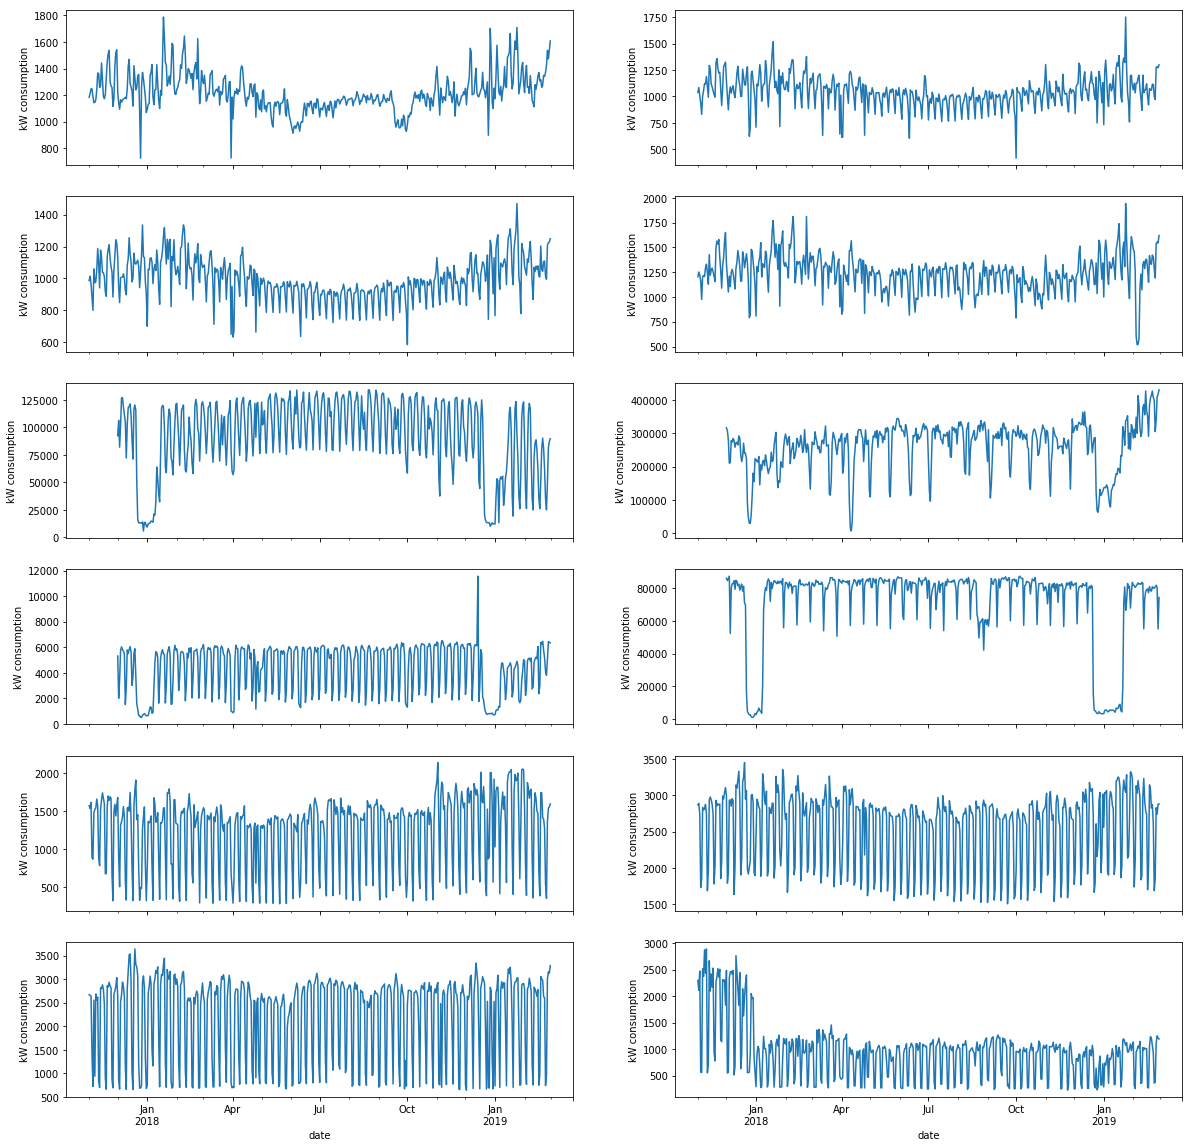

In [13]:
# Confirm visually we are dealing with the same or similar data to chapter 6:
print('Number of time series:',daily_df.shape[1])
fig, axs = plt.subplots(6, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
indices = [0,1,2,3,26,27,33,39,42,43,46,47]
for i in indices:
    plot_num = indices.index(i)
    daily_df[daily_df.columns[i]].loc["2017-11-01":"2019-02-28"].plot(ax=axx[plot_num])
    axx[plot_num].set_xlabel("date")    
    axx[plot_num].set_ylabel("kW consumption")

## Part 3: Create Train and Test Datasets

In [14]:
cats = list(category_df.Category.astype('category').cat.codes)
print(cats)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2]


In [15]:
# stations = list(station_df['Station Number'].astype('category').cat.codes)
# assert len(stations)==48
# print(stations)

In [16]:
usage_per_site = [daily_df[col] for col in daily_df.columns]

print(f'Time series covers {len(usage_per_site[0])} days.')
print(f'Time series starts at {usage_per_site[0].index[0]}')
print(f'Time series ends at {usage_per_site[0].index[-1]}') 
usage_per_site[0][:10]

Time series covers 485 days.
Time series starts at 2017-11-01 00:00:00
Time series ends at 2019-02-28 00:00:00


2017-11-01    1184.23
2017-11-02     1210.9
2017-11-03     1247.6
2017-11-04    1246.92
2017-11-05     1189.2
2017-11-06    1143.62
2017-11-07    1145.66
2017-11-08     1165.5
2017-11-09    1239.25
2017-11-10    1366.25
Freq: D, Name: Site_1, dtype: object

In [17]:
# Do the same for our dynamic features
hols_per_site = [holiday_df[col] for col in holiday_df.columns]
    
print(f'Time series covers {len(hols_per_site[0])} days.')
print(f'Time series starts at {hols_per_site[0].index[0]}')
print(f'Time series ends at {hols_per_site[0].index[-1]}') 
hols_per_site[0][:10]

Time series covers 485 days.
Time series starts at 2017-11-01 00:00:00
Time series ends at 2019-02-28 00:00:00


2017-11-01    0
2017-11-02    0
2017-11-03    0
2017-11-04    0
2017-11-05    0
2017-11-06    0
2017-11-07    0
2017-11-08    0
2017-11-09    0
2017-11-10    0
Name: Site_1_hol, dtype: int64

In [18]:
max_per_site = [max_df[col] for col in max_df.columns]
    
print(f'Time series covers {len(max_per_site[0])} days.')
print(f'Time series starts at {max_per_site[0].index[0]}')
print(f'Time series ends at {max_per_site[0].index[-1]}') 
max_per_site[0][:10]

Time series covers 485 days.
Time series starts at 2017-11-01 00:00:00
Time series ends at 2019-02-28 00:00:00


2017-11-01    20.5
2017-11-02    20.9
2017-11-03    16.2
2017-11-04    18.2
2017-11-05    22.1
2017-11-06    17.2
2017-11-07    17.5
2017-11-08    23.1
2017-11-09    28.5
2017-11-10    31.7
Name: Site_1_max, dtype: float64

In [19]:
freq = 'D'
prediction_length = 28

start_date = pd.Timestamp("2017-11-01", freq=freq)
end_training = pd.Timestamp("2019-01-31", freq=freq)
end_testing = end_training + prediction_length

print(f'End training: {end_training}, End testing: {end_testing}')

End training: 2019-01-31 00:00:00, End testing: 2019-02-28 00:00:00


In [20]:
def write_dicts_to_s3(path, data):
    with s3.open(path, 'wb') as f:
        for d in data:
            f.write(json.dumps(d).encode("utf-8"))
            f.write("\n".encode('utf-8'))

In [21]:
# NOTE: We have missing values in ts for November only.
#       Dynamic features must have numeric values for every entry.
training_data = [
    {
        "cat": [cat],
        "start": str(start_date),
        "target": ts[start_date:end_training].tolist(),
        "dynamic_feat": [
            hols[start_date:end_training].tolist(),
            maxes[start_date:end_training].tolist(),
        ] # Note: List of lists
    }
    for cat,ts,hols,maxes in zip(cats, usage_per_site, hols_per_site, max_per_site)
]

test_data = [
    {
        "cat": [cat],
        "start": str(start_date),
        "target": ts[start_date:end_testing].tolist(),
        "dynamic_feat": [
            hols[start_date:end_testing].tolist(),
            maxes[start_date:end_testing].tolist(),
        ] # Note: List of lists
    }
    for cat,ts,hols,maxes in zip(cats, usage_per_site, hols_per_site, max_per_site)
]
            
write_dicts_to_s3(f'{s3_data_path}/train/train.json', training_data)
write_dicts_to_s3(f'{s3_data_path}/test/test.json', test_data)

## Part 4: Set up session and configure model

In [22]:
s3_output_path = f's3://{data_bucket}/{subfolder}/output'
sess = sagemaker.Session()
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(sess.boto_region_name, "forecasting-deepar", "latest")

data_channels = {
    "train": f"{s3_data_path}/train/",
    "test": f"{s3_data_path}/test/"
}
np.random.seed(42)
random.seed(42)

In [23]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
# Reuse the class from Chapter 6:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        prediction_time = ts.index[-1] + 1
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)        
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    #Given a pandas.Series object, returns a dictionary encoding the time series.
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

## Part 5a: Create model without using additional datasets

First, we will establish a baseline without categorical or dynamic features. Note that this cell is commented out as you only need to run it if you want to see the MAPE without incorporating additional datasets.

In [25]:
# estimator = sagemaker.estimator.Estimator(
#     sagemaker_session=sess,
#     image_name=image_name,
#     role=role,
#     train_instance_count=1,
#     train_instance_type='ml.c5.2xlarge', # $0.476 per hour as of Jan 2019.
#     base_job_name='ch7-energy-usage-baseline',
#     output_path=s3_output_path
# )

# estimator.set_hyperparameters(
#     cardinality='ignore', # DISABLES CATEGORICALS FOR BASELINE
#     context_length="90",
#     prediction_length=str(prediction_length),
#     time_freq=freq,
#     epochs="400",
#     early_stopping_patience="40",
#     mini_batch_size="64",
#     learning_rate="5E-4",
#     num_dynamic_feat="ignore", # DISABLE DYNAMIC FEATURES FOR BASELINE
# )

# estimator.fit(inputs=data_channels, wait=True)

# endpoint_name = 'energy-usage-baseline'

# try:
#     sess.delete_endpoint(
#         sagemaker.predictor.RealTimePredictor(endpoint=endpoint_name).endpoint)
#     print('Warning: Existing endpoint and configuration deleted to make way for your new endpoint.')
#     from time import sleep
#     sleep(30)
# except:
#     pass

# predictor = estimator.deploy(
#     initial_instance_count=1,
#     instance_type='ml.m5.large',
#     predictor_cls=DeepARPredictor,
#     endpoint_name=endpoint_name)

# # Gather 28 day predictions for all timeseries
# usages = [ts[end_training+1:end_training+28].sum() for ts in usage_per_site]

# predictions= []
# for s in range(len(usage_per_site)):
#     # call the end point to get the 28 day prediction
#     predictions.append(
#         predictor.predict(
#             ts=usage_per_site[s][start_date+30:end_training],
#         )['0.5'].sum()
#     )
    
# print(f'MAPE: {round(mape(usages, predictions),1)}%')    

## Part 5b: Model incorporating additional datasets

In [26]:
%%time
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sess,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c5.2xlarge', # $0.476 per hour as of Jan 2019.
    base_job_name='ch7-energy-usage-dynamic',
    output_path=s3_output_path
)

estimator.set_hyperparameters(
    context_length="90",
    prediction_length=str(prediction_length),
    time_freq=freq,
    epochs="400",
    early_stopping_patience="40",
    mini_batch_size="64",
    learning_rate="5E-4",
    num_dynamic_feat=2,
)

estimator.fit(inputs=data_channels, wait=True)

INFO:sagemaker:Creating training-job with name: ch7-energy-usage-dynamic-2019-05-23-23-25-32-148


2019-05-23 23:25:32 Starting - Starting the training job...
2019-05-23 23:25:34 Starting - Launching requested ML instances......
2019-05-23 23:26:39 Starting - Preparing the instances for training...
2019-05-23 23:27:31 Downloading - Downloading input data.....
Arguments: train
[05/23/2019 23:28:13 INFO 139674120660800] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[05/23/2019 23:28:13 INFO 139674120660800] Reading provided configuration from /opt


2019-05-23 23:28:12 Training - Training image download completed. Training in progress.[05/23/2019 23:28:18 INFO 139674120660800] Epoch[2] Batch[0] avg_epoch_loss=7.462043
[05/23/2019 23:28:18 INFO 139674120660800] #quality_metric: host=algo-1, epoch=2, batch=0 train loss <loss>=7.46204328537
[05/23/2019 23:28:18 INFO 139674120660800] Epoch[2] Batch[5] avg_epoch_loss=7.680720
[05/23/2019 23:28:18 INFO 139674120660800] #quality_metric: host=algo-1, epoch=2, batch=5 train loss <loss>=7.68072040876
[05/23/2019 23:28:18 INFO 139674120660800] Epoch[2] Batch [5]#011Speed: 424.87 samples/sec#011loss=7.680720
[05/23/2019 23:28:19 INFO 139674120660800] processed a total of 631 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1684.48805809021, "sum": 1684.48805809021, "min": 1684.48805809021}}, "EndTime": 1558654099.344222, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1558654097.659675}

[05/23/2019 23:28:19 INFO 13967412066

[05/23/2019 23:28:27 INFO 139674120660800] Epoch[8] Batch[0] avg_epoch_loss=6.827698
[05/23/2019 23:28:27 INFO 139674120660800] #quality_metric: host=algo-1, epoch=8, batch=0 train loss <loss>=6.82769775391
[05/23/2019 23:28:28 INFO 139674120660800] Epoch[8] Batch[5] avg_epoch_loss=7.006311
[05/23/2019 23:28:28 INFO 139674120660800] #quality_metric: host=algo-1, epoch=8, batch=5 train loss <loss>=7.00631054242
[05/23/2019 23:28:28 INFO 139674120660800] Epoch[8] Batch [5]#011Speed: 473.06 samples/sec#011loss=7.006311
[05/23/2019 23:28:29 INFO 139674120660800] Epoch[8] Batch[10] avg_epoch_loss=6.898046
[05/23/2019 23:28:29 INFO 139674120660800] #quality_metric: host=algo-1, epoch=8, batch=10 train loss <loss>=6.76812839508
[05/23/2019 23:28:29 INFO 139674120660800] Epoch[8] Batch [10]#011Speed: 486.87 samples/sec#011loss=6.768128
[05/23/2019 23:28:29 INFO 139674120660800] processed a total of 666 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1645.521879196167, "sum": 

[05/23/2019 23:28:38 INFO 139674120660800] processed a total of 640 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1494.2080974578857, "sum": 1494.2080974578857, "min": 1494.2080974578857}}, "EndTime": 1558654118.4251, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1558654116.930635}

[05/23/2019 23:28:38 INFO 139674120660800] #throughput_metric: host=algo-1, train throughput=428.294148159 records/second
[05/23/2019 23:28:38 INFO 139674120660800] #progress_metric: host=algo-1, completed 3 % of epochs
[05/23/2019 23:28:38 INFO 139674120660800] #quality_metric: host=algo-1, epoch=14, train loss <loss>=6.7632481575
[05/23/2019 23:28:38 INFO 139674120660800] loss did not improve
[05/23/2019 23:28:38 INFO 139674120660800] Epoch[15] Batch[0] avg_epoch_loss=6.766818
[05/23/2019 23:28:38 INFO 139674120660800] #quality_metric: host=algo-1, epoch=15, batch=0 train loss <loss>=6.76681756973
[05/23/2019 23:28:39 INFO 1396741206

[05/23/2019 23:28:48 INFO 139674120660800] Epoch[21] Batch[0] avg_epoch_loss=6.227064
[05/23/2019 23:28:48 INFO 139674120660800] #quality_metric: host=algo-1, epoch=21, batch=0 train loss <loss>=6.22706413269
[05/23/2019 23:28:48 INFO 139674120660800] Epoch[21] Batch[5] avg_epoch_loss=6.624216
[05/23/2019 23:28:48 INFO 139674120660800] #quality_metric: host=algo-1, epoch=21, batch=5 train loss <loss>=6.62421592077
[05/23/2019 23:28:48 INFO 139674120660800] Epoch[21] Batch [5]#011Speed: 484.84 samples/sec#011loss=6.624216
[05/23/2019 23:28:49 INFO 139674120660800] processed a total of 634 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1517.1029567718506, "sum": 1517.1029567718506, "min": 1517.1029567718506}}, "EndTime": 1558654129.412155, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1558654127.894996}

[05/23/2019 23:28:49 INFO 139674120660800] #throughput_metric: host=algo-1, train throughput=417.876085513 records

[05/23/2019 23:28:58 INFO 139674120660800] Epoch[27] Batch[5] avg_epoch_loss=6.425131
[05/23/2019 23:28:58 INFO 139674120660800] #quality_metric: host=algo-1, epoch=27, batch=5 train loss <loss>=6.42513108253
[05/23/2019 23:28:58 INFO 139674120660800] Epoch[27] Batch [5]#011Speed: 481.18 samples/sec#011loss=6.425131
[05/23/2019 23:28:58 INFO 139674120660800] processed a total of 627 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1499.7448921203613, "sum": 1499.7448921203613, "min": 1499.7448921203613}}, "EndTime": 1558654138.778966, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1558654137.278912}

[05/23/2019 23:28:58 INFO 139674120660800] #throughput_metric: host=algo-1, train throughput=418.04544943 records/second
[05/23/2019 23:28:58 INFO 139674120660800] #progress_metric: host=algo-1, completed 7 % of epochs
[05/23/2019 23:28:58 INFO 139674120660800] #quality_metric: host=algo-1, epoch=27, train loss <loss>=6.4

[05/23/2019 23:29:08 INFO 139674120660800] processed a total of 621 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1482.100009918213, "sum": 1482.100009918213, "min": 1482.100009918213}}, "EndTime": 1558654148.078671, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1558654146.596247}

[05/23/2019 23:29:08 INFO 139674120660800] #throughput_metric: host=algo-1, train throughput=418.974588033 records/second
[05/23/2019 23:29:08 INFO 139674120660800] #progress_metric: host=algo-1, completed 8 % of epochs
[05/23/2019 23:29:08 INFO 139674120660800] #quality_metric: host=algo-1, epoch=33, train loss <loss>=6.30915293694
[05/23/2019 23:29:08 INFO 139674120660800] loss did not improve
[05/23/2019 23:29:08 INFO 139674120660800] Epoch[34] Batch[0] avg_epoch_loss=6.093351
[05/23/2019 23:29:08 INFO 139674120660800] #quality_metric: host=algo-1, epoch=34, batch=0 train loss <loss>=6.0933508873
[05/23/2019 23:29:09 INFO 13967412066

[05/23/2019 23:29:17 INFO 139674120660800] Epoch[40] Batch[5] avg_epoch_loss=6.130837
[05/23/2019 23:29:17 INFO 139674120660800] #quality_metric: host=algo-1, epoch=40, batch=5 train loss <loss>=6.13083736102
[05/23/2019 23:29:17 INFO 139674120660800] Epoch[40] Batch [5]#011Speed: 490.09 samples/sec#011loss=6.130837
[05/23/2019 23:29:18 INFO 139674120660800] processed a total of 627 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1485.0618839263916, "sum": 1485.0618839263916, "min": 1485.0618839263916}}, "EndTime": 1558654158.494508, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1558654157.009081}

[05/23/2019 23:29:18 INFO 139674120660800] #throughput_metric: host=algo-1, train throughput=422.178194247 records/second
[05/23/2019 23:29:18 INFO 139674120660800] #progress_metric: host=algo-1, completed 10 % of epochs
[05/23/2019 23:29:18 INFO 139674120660800] #quality_metric: host=algo-1, epoch=40, train loss <loss>=6

[05/23/2019 23:29:28 INFO 139674120660800] Epoch[47] Batch[0] avg_epoch_loss=6.250419
[05/23/2019 23:29:28 INFO 139674120660800] #quality_metric: host=algo-1, epoch=47, batch=0 train loss <loss>=6.25041866302
[05/23/2019 23:29:28 INFO 139674120660800] Epoch[47] Batch[5] avg_epoch_loss=6.400197
[05/23/2019 23:29:28 INFO 139674120660800] #quality_metric: host=algo-1, epoch=47, batch=5 train loss <loss>=6.40019710859
[05/23/2019 23:29:28 INFO 139674120660800] Epoch[47] Batch [5]#011Speed: 483.60 samples/sec#011loss=6.400197
[05/23/2019 23:29:29 INFO 139674120660800] processed a total of 635 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1509.1722011566162, "sum": 1509.1722011566162, "min": 1509.1722011566162}}, "EndTime": 1558654169.382847, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1558654167.873419}

[05/23/2019 23:29:29 INFO 139674120660800] #throughput_metric: host=algo-1, train throughput=420.734876891 records

[05/23/2019 23:29:43 INFO 139674120660800] processed a total of 625 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1468.919038772583, "sum": 1468.919038772583, "min": 1468.919038772583}}, "EndTime": 1558654183.375635, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1558654181.906455}

[05/23/2019 23:29:43 INFO 139674120660800] #throughput_metric: host=algo-1, train throughput=425.457188273 records/second
[05/23/2019 23:29:43 INFO 139674120660800] #progress_metric: host=algo-1, completed 14 % of epochs
[05/23/2019 23:29:43 INFO 139674120660800] #quality_metric: host=algo-1, epoch=56, train loss <loss>=6.37199554443
[05/23/2019 23:29:43 INFO 139674120660800] loss did not improve
[05/23/2019 23:29:43 INFO 139674120660800] Epoch[57] Batch[0] avg_epoch_loss=6.584301
[05/23/2019 23:29:43 INFO 139674120660800] #quality_metric: host=algo-1, epoch=57, batch=0 train loss <loss>=6.58430051804
[05/23/2019 23:29:44 INFO 139674120

[05/23/2019 23:29:53 INFO 139674120660800] Epoch[63] Batch[5] avg_epoch_loss=6.066259
[05/23/2019 23:29:53 INFO 139674120660800] #quality_metric: host=algo-1, epoch=63, batch=5 train loss <loss>=6.06625906626
[05/23/2019 23:29:53 INFO 139674120660800] Epoch[63] Batch [5]#011Speed: 488.09 samples/sec#011loss=6.066259
[05/23/2019 23:29:54 INFO 139674120660800] Epoch[63] Batch[10] avg_epoch_loss=6.099361
[05/23/2019 23:29:54 INFO 139674120660800] #quality_metric: host=algo-1, epoch=63, batch=10 train loss <loss>=6.13908348083
[05/23/2019 23:29:54 INFO 139674120660800] Epoch[63] Batch [10]#011Speed: 463.31 samples/sec#011loss=6.139083
[05/23/2019 23:29:54 INFO 139674120660800] processed a total of 652 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1652.1940231323242, "sum": 1652.1940231323242, "min": 1652.1940231323242}}, "EndTime": 1558654194.240728, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1558654192.588159}

[0

[05/23/2019 23:30:13 INFO 139674120660800] Epoch[76] Batch[0] avg_epoch_loss=6.181801
[05/23/2019 23:30:13 INFO 139674120660800] #quality_metric: host=algo-1, epoch=76, batch=0 train loss <loss>=6.18180084229
[05/23/2019 23:30:13 INFO 139674120660800] Epoch[76] Batch[5] avg_epoch_loss=6.294086
[05/23/2019 23:30:13 INFO 139674120660800] #quality_metric: host=algo-1, epoch=76, batch=5 train loss <loss>=6.29408589999
[05/23/2019 23:30:13 INFO 139674120660800] Epoch[76] Batch [5]#011Speed: 486.85 samples/sec#011loss=6.294086
[05/23/2019 23:30:14 INFO 139674120660800] Epoch[76] Batch[10] avg_epoch_loss=6.220138
[05/23/2019 23:30:14 INFO 139674120660800] #quality_metric: host=algo-1, epoch=76, batch=10 train loss <loss>=6.13139944077
[05/23/2019 23:30:14 INFO 139674120660800] Epoch[76] Batch [10]#011Speed: 486.37 samples/sec#011loss=6.131399
[05/23/2019 23:30:14 INFO 139674120660800] processed a total of 673 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1654.6831130981445

[05/23/2019 23:30:23 INFO 139674120660800] Epoch[82] Batch[5] avg_epoch_loss=6.173356
[05/23/2019 23:30:23 INFO 139674120660800] #quality_metric: host=algo-1, epoch=82, batch=5 train loss <loss>=6.17335589727
[05/23/2019 23:30:23 INFO 139674120660800] Epoch[82] Batch [5]#011Speed: 482.19 samples/sec#011loss=6.173356
[05/23/2019 23:30:23 INFO 139674120660800] processed a total of 602 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1516.7851448059082, "sum": 1516.7851448059082, "min": 1516.7851448059082}}, "EndTime": 1558654223.816131, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1558654222.299037}

[05/23/2019 23:30:23 INFO 139674120660800] #throughput_metric: host=algo-1, train throughput=396.867743603 records/second
[05/23/2019 23:30:23 INFO 139674120660800] #progress_metric: host=algo-1, completed 20 % of epochs
[05/23/2019 23:30:23 INFO 139674120660800] #quality_metric: host=algo-1, epoch=82, train loss <loss>=6

[05/23/2019 23:30:33 INFO 139674120660800] Epoch[88] Batch[10] avg_epoch_loss=6.123742
[05/23/2019 23:30:33 INFO 139674120660800] #quality_metric: host=algo-1, epoch=88, batch=10 train loss <loss>=6.18838033676
[05/23/2019 23:30:33 INFO 139674120660800] Epoch[88] Batch [10]#011Speed: 491.06 samples/sec#011loss=6.188380
[05/23/2019 23:30:33 INFO 139674120660800] processed a total of 679 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1622.6940155029297, "sum": 1622.6940155029297, "min": 1622.6940155029297}}, "EndTime": 1558654233.15034, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1558654231.527388}

[05/23/2019 23:30:33 INFO 139674120660800] #throughput_metric: host=algo-1, train throughput=418.417755086 records/second
[05/23/2019 23:30:33 INFO 139674120660800] #progress_metric: host=algo-1, completed 22 % of epochs
[05/23/2019 23:30:33 INFO 139674120660800] #quality_metric: host=algo-1, epoch=88, train loss <loss>

[05/23/2019 23:30:43 INFO 139674120660800] Epoch[95] Batch[0] avg_epoch_loss=6.554397
[05/23/2019 23:30:43 INFO 139674120660800] #quality_metric: host=algo-1, epoch=95, batch=0 train loss <loss>=6.55439662933
[05/23/2019 23:30:43 INFO 139674120660800] Epoch[95] Batch[5] avg_epoch_loss=6.100346
[05/23/2019 23:30:43 INFO 139674120660800] #quality_metric: host=algo-1, epoch=95, batch=5 train loss <loss>=6.10034648577
[05/23/2019 23:30:43 INFO 139674120660800] Epoch[95] Batch [5]#011Speed: 488.90 samples/sec#011loss=6.100346
[05/23/2019 23:30:44 INFO 139674120660800] Epoch[95] Batch[10] avg_epoch_loss=6.091320
[05/23/2019 23:30:44 INFO 139674120660800] #quality_metric: host=algo-1, epoch=95, batch=10 train loss <loss>=6.08048915863
[05/23/2019 23:30:44 INFO 139674120660800] Epoch[95] Batch [10]#011Speed: 467.67 samples/sec#011loss=6.080489
[05/23/2019 23:30:44 INFO 139674120660800] processed a total of 653 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1636.357069015503,

[05/23/2019 23:30:53 INFO 139674120660800] Epoch[101] Batch[5] avg_epoch_loss=6.070672
[05/23/2019 23:30:53 INFO 139674120660800] #quality_metric: host=algo-1, epoch=101, batch=5 train loss <loss>=6.07067219416
[05/23/2019 23:30:53 INFO 139674120660800] Epoch[101] Batch [5]#011Speed: 491.73 samples/sec#011loss=6.070672
[05/23/2019 23:30:53 INFO 139674120660800] processed a total of 640 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1471.4610576629639, "sum": 1471.4610576629639, "min": 1471.4610576629639}}, "EndTime": 1558654253.805581, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1558654252.333826}

[05/23/2019 23:30:53 INFO 139674120660800] #throughput_metric: host=algo-1, train throughput=434.91408908 records/second
[05/23/2019 23:30:53 INFO 139674120660800] #progress_metric: host=algo-1, completed 25 % of epochs
[05/23/2019 23:30:53 INFO 139674120660800] #quality_metric: host=algo-1, epoch=101, train loss <loss

[05/23/2019 23:31:03 INFO 139674120660800] processed a total of 599 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1509.1919898986816, "sum": 1509.1919898986816, "min": 1509.1919898986816}}, "EndTime": 1558654263.324202, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1558654261.814705}

[05/23/2019 23:31:03 INFO 139674120660800] #throughput_metric: host=algo-1, train throughput=396.873727242 records/second
[05/23/2019 23:31:03 INFO 139674120660800] #progress_metric: host=algo-1, completed 27 % of epochs
[05/23/2019 23:31:03 INFO 139674120660800] #quality_metric: host=algo-1, epoch=107, train loss <loss>=6.37763390541
[05/23/2019 23:31:03 INFO 139674120660800] loss did not improve
[05/23/2019 23:31:03 INFO 139674120660800] Epoch[108] Batch[0] avg_epoch_loss=6.016160
[05/23/2019 23:31:03 INFO 139674120660800] #quality_metric: host=algo-1, epoch=108, batch=0 train loss <loss>=6.01616001129
[05/23/2019 23:31:04 INFO 139

[05/23/2019 23:31:13 INFO 139674120660800] Epoch[114] Batch[0] avg_epoch_loss=5.760945
[05/23/2019 23:31:13 INFO 139674120660800] #quality_metric: host=algo-1, epoch=114, batch=0 train loss <loss>=5.76094532013
[05/23/2019 23:31:13 INFO 139674120660800] Epoch[114] Batch[5] avg_epoch_loss=6.031717
[05/23/2019 23:31:13 INFO 139674120660800] #quality_metric: host=algo-1, epoch=114, batch=5 train loss <loss>=6.03171714147
[05/23/2019 23:31:13 INFO 139674120660800] Epoch[114] Batch [5]#011Speed: 484.47 samples/sec#011loss=6.031717
[05/23/2019 23:31:14 INFO 139674120660800] Epoch[114] Batch[10] avg_epoch_loss=6.062783
[05/23/2019 23:31:14 INFO 139674120660800] #quality_metric: host=algo-1, epoch=114, batch=10 train loss <loss>=6.1000617981
[05/23/2019 23:31:14 INFO 139674120660800] Epoch[114] Batch [10]#011Speed: 469.12 samples/sec#011loss=6.100062
[05/23/2019 23:31:14 INFO 139674120660800] processed a total of 665 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1652.086019

[05/23/2019 23:31:23 INFO 139674120660800] Epoch[120] Batch[5] avg_epoch_loss=5.923056
[05/23/2019 23:31:23 INFO 139674120660800] #quality_metric: host=algo-1, epoch=120, batch=5 train loss <loss>=5.92305636406
[05/23/2019 23:31:23 INFO 139674120660800] Epoch[120] Batch [5]#011Speed: 489.64 samples/sec#011loss=5.923056
[05/23/2019 23:31:24 INFO 139674120660800] Epoch[120] Batch[10] avg_epoch_loss=6.096000
[05/23/2019 23:31:24 INFO 139674120660800] #quality_metric: host=algo-1, epoch=120, batch=10 train loss <loss>=6.30353212357
[05/23/2019 23:31:24 INFO 139674120660800] Epoch[120] Batch [10]#011Speed: 465.98 samples/sec#011loss=6.303532
[05/23/2019 23:31:24 INFO 139674120660800] processed a total of 653 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1649.0938663482666, "sum": 1649.0938663482666, "min": 1649.0938663482666}}, "EndTime": 1558654284.230839, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1558654282.58148

[05/23/2019 23:31:33 INFO 139674120660800] Epoch[126] Batch[5] avg_epoch_loss=6.277166
[05/23/2019 23:31:33 INFO 139674120660800] #quality_metric: host=algo-1, epoch=126, batch=5 train loss <loss>=6.27716620763
[05/23/2019 23:31:33 INFO 139674120660800] Epoch[126] Batch [5]#011Speed: 482.66 samples/sec#011loss=6.277166
[05/23/2019 23:31:33 INFO 139674120660800] processed a total of 636 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1484.724998474121, "sum": 1484.724998474121, "min": 1484.724998474121}}, "EndTime": 1558654293.633779, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1558654292.148728}

[05/23/2019 23:31:33 INFO 139674120660800] #throughput_metric: host=algo-1, train throughput=428.339319045 records/second
[05/23/2019 23:31:33 INFO 139674120660800] #progress_metric: host=algo-1, completed 31 % of epochs
[05/23/2019 23:31:33 INFO 139674120660800] #quality_metric: host=algo-1, epoch=126, train loss <loss>=


2019-05-23 23:31:51 Uploading - Uploading generated training model
2019-05-23 23:31:51 Completed - Training job completed
Billable seconds: 261
CPU times: user 955 ms, sys: 72.6 ms, total: 1.03 s
Wall time: 6min 44s


## Part 6. Making predictions from the model that incorporates additional datasets

In [27]:
endpoint_name = 'energy-usage-dynamic'

try:
    sess.delete_endpoint(
        sagemaker.predictor.RealTimePredictor(endpoint=endpoint_name).endpoint)
    print('Warning: Existing endpoint and configuration deleted to make way for your new endpoint.')
    from time import sleep
    sleep(30)
except:
    pass

INFO:sagemaker:Deleting endpoint with name: energy-usage-dynamic


In [ ]:
%%time
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    predictor_cls=DeepARPredictor,
    endpoint_name=endpoint_name)

INFO:sagemaker:Creating model with name: forecasting-deepar-2019-05-23-23-32-47-119
INFO:sagemaker:Creating endpoint with name energy-usage-dynamic


----------------------------------------------------------------------

In [ ]:
# Test prediction: (Delete endpoint configuration if retrying)
predictor.predict(
    cat=[cats[0]],
    ts=usage_per_site[0][start_date+30:end_training],
     dynamic_feat=[
             hols_per_site[0][start_date+30:end_training+28].tolist(),
             max_per_site[0][start_date+30:end_training+28].tolist(),
         ],
    quantiles=[0.1, 0.5, 0.9]
).head()

In [ ]:
# Gather 28 day predictions for all timeseries
usages = [ts[end_training+1:end_training+28].sum() for ts in usage_per_site]

predictions= []
for s in range(len(usage_per_site)):
    # call the end point to get the 28 day prediction
    predictions.append(
        predictor.predict(
            cat=[cats[s]],
            ts=usage_per_site[s][start_date+30:end_training],
            dynamic_feat=[
                hols_per_site[s][start_date+30:end_training+28].tolist(),
                max_per_site[s][start_date+30:end_training+28].tolist(),
             ]
        )['0.5'].sum()
    )

for p,u in zip(predictions,usages):
    print(f'Predicted {p} kwh but usage was {u} kwh.')

In [ ]:
print(f'MAPE: {round(mape(usages, predictions),1)}%')

That's a really impressive improvement from 21%. What does this look like visually?

In [ ]:
def plot(
    predictor, 
    site_id,
    end_training=end_training, 
    plot_weeks=12,
    confidence=80
):
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5
    target_ts = usage_per_site[site_id][start_date+30:]
    dynamic_feats = [
            hols_per_site[site_id][start_date+30:].tolist(),
            max_per_site[site_id][start_date+30:].tolist(),
        ]
        
    plot_history = plot_weeks * 7

    fig = plt.figure(figsize=(20, 3))
    ax = plt.subplot(1,1,1)
    
    prediction = predictor.predict(
        cat = [cats[site_id]],
        ts=target_ts[:end_training],
        dynamic_feat=dynamic_feats,
        quantiles=[low_quantile, 0.5, up_quantile])
                
    target_section = target_ts[end_training-plot_history:end_training+prediction_length]
    target_section.plot(color="black", label='target')
    
    ax.fill_between(
        prediction[str(low_quantile)].index, 
        prediction[str(low_quantile)].values, 
        prediction[str(up_quantile)].values, 
        color="b", alpha=0.3, label='{}% confidence interval'.format(confidence)
    )  
    
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)

In [ ]:
# Plot 4 of each category:
indices = [2,26,33,39,42,47,3]
for i in indices:
    plot_num = indices.index(i)
    plot(
        predictor,
        site_id=i,
        plot_weeks=6,
        confidence=80
    )

## Part 7. Remove the Endpoints

In [ ]:
# Remove the Endpoint
# Comment out this cell to remove the endpoint if you want the endpoint to exist after "run all"

# sess.delete_endpoint('energy-usage-baseline')
# sess.delete_endpoint('energy-usage-dynamic')